<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <a href="" target="_blank">
  <img alt='Thumbnail for a video showing 3 cool Google Colab features' src="https://lh3.googleusercontent.com/8f6KyXu7OCkY5E4BC1v7kgFbzpscRsT326y8SwrClbMc3ptYRqMHcccIituJQOivN4iP4xCNGbVKLatIvLfnwOEdaJTxNf1YDViDy35FeXh8daUdOyxOqGr0DgLtUoAteTNlqLwneRo24R7JY84i7SebCYo4F5TtmFHA3wsmDS-RIYyAFkmhTEsT4QKR0BvKW6lYnwNy_pjAMXL35JGIchtBFfIFsIzGVKtZLldsOmbFb3D_Ly71HmQvy2zi3xSwe_PLs8aUZ4BjR4sorbomNULOKh6zave_pL0O559h4gcs-r2U5AZLRJaxS-SXhFfUhEPC6I0WPJW3IFpDOqZFP7HFVUPyXwbWvh8jTtl8_hBOJW1GeD7xBqojQxEykMVa7tCIEhbA8izuXVhFZF88qvqFVsspfbtN6Cy3_wL3ksVrzXg-PJ1dXDPvpMwPLxpZV-haviWEuPxDtT_weV6pKgFmEwHmHH9rgPQIXmxStupc-dBGl647taYVeUUmncmTVTIMBBCQMcZByRzf3oKptFwYdGy6Yer-xjYvZ523_VNn4ni_YNU9f4mTaeCKN2AlScHHhrFfDKUTHyuQsbtOjh67GVXSi5j2ibK2Y1VJe7uMr6171k1m232F0d63k4EksMreQRbbVbtflYpcKB7epF1FY6P8SHCWvAKBJjS60joXBYaUdQQly6GreRAtnKkokfy9LJVfn7kC_0nyT0Eth4g_Y1GN3LyHPrmr3dHqrz38B3kaDpsdoyeM5ZGYeglPTz2UKbgHtLXVrK-cfnfORxQf8Ax4jK-VQtxx_v6d6MHPGd18KaSfGRdvYI-EGpIohPLWYlIfvjyuNylJKUU7rWBXHw0vNfHdvtiiI_dw9ZIiY84OqtXRubBPAPMFz--fvZWi17cBDpKOTR-BeK_SJautIcIA3P8QxhimZTw4C3pEIxnouQy22cuUtth2OKkPtTG4lgJIubSPYKxVN9ppVECJRZSefLOBV2giOWgJyZW-Xgr3VygyB2A9=w1658-h269-no?authuser=1" >
  </a>
</center>



# Code

In [9]:
from google.colab import drive
drive.mount('/content/drive')
import scipy
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns

from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table,perimeter
from skimage.color import label2rgb



Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
class ImageData:
    def __init__(self, img, metadata):

        """Class for storing image data and metadata.

        Args:
            img (numpy.ndarray): The image data as a numpy array.
            metadata (dict): A dictionary containing metadata for the image.
        """
        self.img = img
        self.metadata = metadata

def load_file(filepath: str) -> ImageData:

    """Load an image and its metadata from a file.

    Args:
        filepath (str): The path to the file containing the image.

    Returns:
        An ImageData object containing the image data and metadata.
    """
    # Load the image from the specified file path
    img = io.imread(filepath, as_gray=True)
    img = img.astype(np.int32)
    
    # Load metadata from the corresponding txt file
    txtfile= filepath.split('.')[0]+'.txt'
    with open(txtfile,'r') as txt_file:
        txt = txt_file.read()
        txt=txt.split('\n')
        txt=txt[1:-1]
        sem_dict = {}
        for row in txt:
            row = row.split('=')
            sem_dict.update({row[0]:  row[1]}) 
    
    # Process metadata and print relevant information
    width, height = map(int, sem_dict['DataSize'].split('x'))
    pixelsize = float(sem_dict['PixelSize'])
    image_area = width * pixelsize * height * pixelsize

    # Resize the image if necessary
    if height == 1920:
        img = img[0:1780, 0:2560]
        height = 1780
    sem_dict['height'] = height
    sem_dict['width'] = width
    sem_dict['image_area'] = image_area
    # Display the image with metadata overlaid
    textstr = '\n'.join((
        f'File name: {sem_dict["ImageName"]}',
        f'Pixel size: {pixelsize:.2f} nm',
        f'Image size: {width} x {height} pixels'
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    ax.imshow(img, vmax=255, cmap='gray')
    ax.text(0.02, 0.98, textstr, fontsize=14,
            transform=ax.transAxes, va='top', ha='left', bbox=props)
    plt.tight_layout()
    plt.show()
    print(f'Image loaded successfully from: {filepath}')

    # Return an ImageData object containing the image data and metadata
    return ImageData(img, sem_dict)

In [11]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    im_flatten = im.flatten()
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.figure(figsize=(4,2))
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.yscale('log')
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    plt.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()

In [12]:
def uniform(num_rec_x,num_rec_y):

    """
    Divides an image into a grid of rectangles of equal size, computes the median intensity of each rectangle,
    subtracts it from the rectangle, and returns the resulting image and a binary mask of usable areas.

    Args:
        num_rec_x (int): number of rectangles in the x-axis
        num_rec_y (int): number of rectangles in the y-axis
        image_data (numpy.ndarray): the image data as a 2D numpy array

    Returns:
        img2 (numpy.ndarray): the resulting image after subtracting the median intensity of each rectangle
        median_img (list): a list of median intensities for each rectangle
        mask (numpy.ndarray): a binary mask indicating usable areas
        mask_area (dict): a dictionary containing the areas of usable and non-usable regions in the mask
    """

    # copy the image data
    img = np.copy(image_data.img)
    img2 = img.copy()
    # extract image metadata
    height = image_data.metadata['height']
    width = image_data.metadata['width']

    # calculate the size of each rectangle
    rec_size_x = int(height/ num_rec_x)
    rec_size_y = int(width / num_rec_y)

    # print the median rectangle size and intensity of the image
    print("Median Rectangle Box size:", rec_size_x, "x", rec_size_y)
    print("Median intensity:", np.median(img))

    # initialize lists and masks
    median_img = []
    mask = np.zeros(shape=(height, width), dtype=bool)

    # iterate over each rectangle

    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            # handle edge case rectangles
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            # compute the median intensity for the rectangle and subtract it from the rectangle
            median_img.append(np.median(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    
    # Compute the upper and lower bounds for the median intensity.
    Q1 = np.percentile(median_img , 25)
    Q3 = np.percentile(median_img , 75)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)

    # Set unusable regions to 0 in the image and mark them in the mask.
    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > upper_bound or np.median(img[x_min:x_max,y_min:y_max]) < lower_bound :
                #print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 0
                mask[x_min:x_max,y_min:y_max] = True
    # Set the border pixels of the mask to True.          
    img2[img2<0] = 0
    mask[0,:]=True
    mask[-1,:]=True
    mask[:,0]=True
    mask[:,-1]=True
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img2,vmax=img2.max())
    plt.show()
    unique, counts = np.unique(mask, return_counts=True)
    mask_area = dict(zip(unique, counts))
   # print('usable area: ',round(mask_area[False]/(mask_area[True]+mask_area[False]),2))
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(mask)
    plt.show()
    return img2, median_img,mask, mask_area

In [13]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))

In [14]:
def segmentation(low,denoise=6,small=15,erosion=1):
    img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_denoised = img2.copy()
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = clear_border(img_segm,
                          mask=np.invert(scipy.ndimage.binary_dilation(mask,iterations=1))
                          )
    img_segm = morphology.area_closing(img_segm)
    for i in range(erosion):
        img_segm = morphology.binary_erosion(img_segm)
    img_segm = morphology.remove_small_objects(img_segm, small)
    for i in range(erosion-1):     
        img_segm = morphology.binary_dilation(img_segm)
    return img_segm

In [43]:
def label_img():
    """
    Labels the segmented image, calculates properties of each labeled region, and returns the labeled image,
    an RGB visualization of the labeled image, and a DataFrame of the region properties.

    Args:
    - image_data (dict): A dictionary containing the image data and metadata.
    - img_segm (numpy array): A binary image of the segmented regions.
    - mask (numpy array): A boolean mask of the region of interest.
    - mask_area (tuple): A tuple containing the area of the region of interest (True pixels) and the total area of the image.

    Returns:
    - img2_label (numpy array): A labeled image.
    - img2_label_overlay (numpy array): An RGB visualization of the labeled image.
    - data_nm (pandas DataFrame): A DataFrame containing the properties of each labeled region.
    """

    # Extract the pixel size from metadata
    pixelsize = float(image_data.metadata['PixelSize'])


    # Make a copy of the image data
    img = np.copy(image_data.img) 


    # Label the segmented image
    img2_label = label(img_segm)


    # Remove labels touching the border of the image
    img2_label = clear_border(img2_label)

    # Create an RGB image for visualization
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    # Calculate properties of each labeled region

    props = regionprops_table(img2_label, img2,
                           properties=['mean_intensity',
                                       'area',
                                       'extent',
                                       'eccentricity',
                                       'convex_area',
                                       'equivalent_diameter',
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image',
                                       'convex_image'
                                       ]
                              )
    # Convert properties to a pandas dataframe
    props = pd.DataFrame(props)


    # Add image data to the properties dataframe
    props['img'] = [img]*len(props)


    # Crop image to the bounding box of each labeled region
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]),
                                  int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()


    # Convert pixel-based measurements to nanometers
    data_nm['convex_perimeter'] = data_nm['convex_image'].apply(lambda x: perimeter(x))

    data_nm = data_nm.drop(columns=[
                                 #   'image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                              #      'img',
                           #         'mean_intensity',
                                  #  'convex_image'
                                    ])
    to_nm = ['equivalent_diameter',
       'major_axis_length', 'minor_axis_length', 'perimeter',
       'feret_diameter_max', 'convex_perimeter']

    to_nm2 = ['area', 'convex_area']
    data_nm['circularity'] = np.sqrt(4*np.pi*data_nm['area']/(data_nm['perimeter'])**2)
    data_nm.loc[data_nm['circularity'] >1 ,'circularity'] = 1
    for column in to_nm:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize)
    for column in to_nm2:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize*pixelsize)


    #Calculate addition parameters
    data_nm['aspect_ratio'] = data_nm['minor_axis_length']/data_nm['major_axis_length']
    data_nm['solidity'] =data_nm['area']/data_nm['convex_area']
    data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'convex_perimeter'] = data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'perimeter'].values
    data_nm['convexity'] = data_nm['convex_perimeter']/data_nm['perimeter']
    data_nm['filename'] = image_data.metadata['ImageName'].split('.')[0]
    unique, counts = np.unique(mask, return_counts=True)
    
    data_nm['area_fraction']=data_nm['area']*mask_area[False]/(mask_area[True]+mask_area[False])


    #Save DataFrame in CSV file
    csv_file_name=image_data.metadata['ImageName'].split('.')[0]
    data_nm.to_csv(csv_file_name+'.csv')

    
    return img2_label, img2_label_overlay, data_nm

In [32]:
def quick_label_img():
    img2_label = label(img_segm)
    img2_label = clear_border(img2_label, mask=mask)
    particles = img2_label.max()
    return particles

# Single File

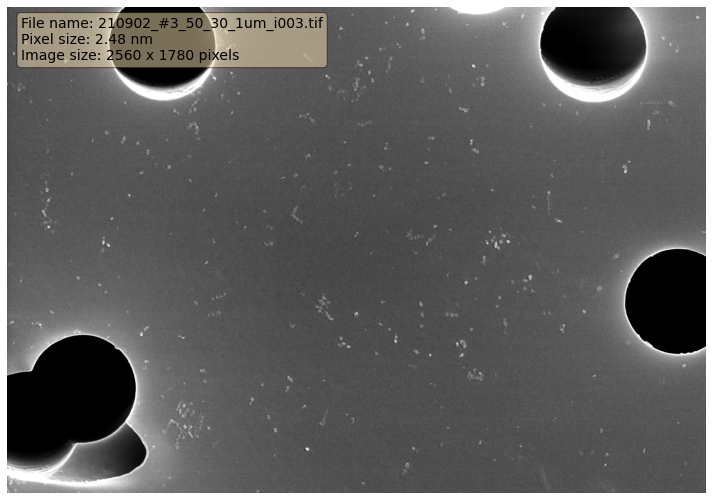

Image loaded successfully from: /content/drive/MyDrive/CIOP/images/#50/210902_#3_50_30_1um_i003.tif


In [17]:
#@title Load File

file_path = '/content/drive/MyDrive/CIOP/images/#50/210902_#3_50_30_1um_i003.tif' #@param {type:"string"}
show_info = False #@param {type:"boolean"}
image_data = load_file(file_path)
if show_info:
    print(pd.DataFrame(image_data.metadata,index=[0]).T)

Median Rectangle Box size: 178 x 256
Median intensity: 85.0


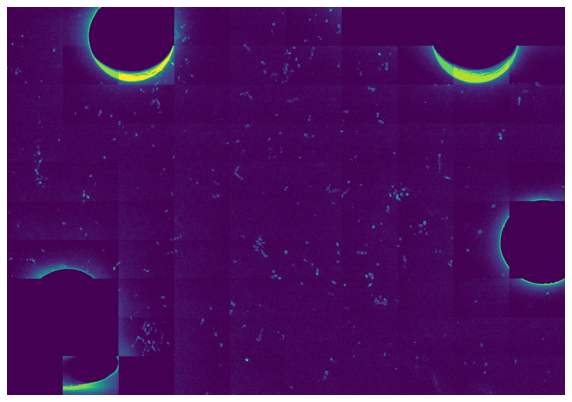

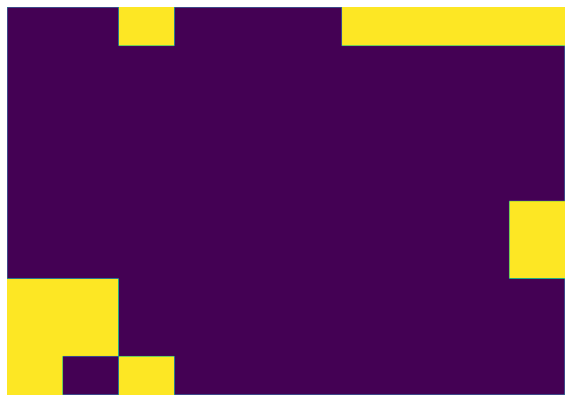

In [18]:
#@title Number of rectangles [x:x]
#@markdown Insert number of rectangles in the image 
number_slider = 10 #@param {type:"slider", min:2, max:50, step:2}
img2, median_img,mask, mask_area = uniform(number_slider,number_slider)

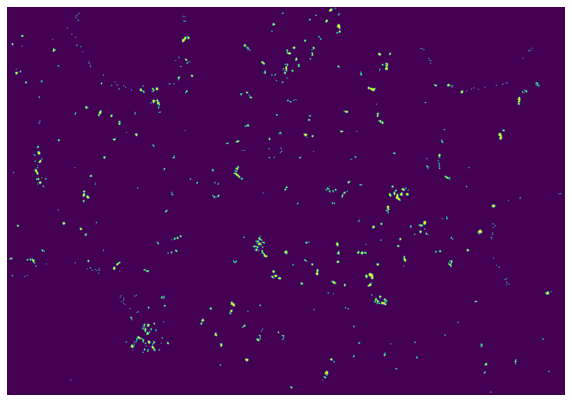

503

In [42]:
#@title Segmentation and labeling
#@title ## Markdown
#@markdown Image Segmentation
low = 25 #@param {type:"slider", min:1, max:50, step:1}
denoise = 2 #@param {type:"slider", min:1, max:10, step:1}
small = 10 #@param {type:"slider", min:0, max:50, step:1}
erosion =0 #@param {type:"slider", min:0, max:5, step:1}

img_segm = segmentation(low, denoise,small,erosion)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_segm)
plt.show()
img2_label, img2_label_overlay, data_nm = label_img()
len(data_nm)

# Iteration

In [ ]:
df = pd.DataFrame()

In [ ]:
low_adj = 0

In [ ]:
#@title 50 clean
#@title ## Markdown
#@markdown Insert number of rectangles in the image 
number_slider = 20 #@param {type:"slider", min:2, max:50, step:2}

denoise = 1 #@param {type:"slider", min:1, max:10, step:1}
small = 40 #@param {type:"slider", min:0, max:80, step:1}
erosion =0 #@param {type:"slider", min:0, max:5, step:1}

cut_off_min = 1 #@param {type:"slider", min:0, max:50, step:1}
cut_off_max = 40 #@param {type:"slider", min:0, max:50, step:1}
cut_off_step = 1 #@param {type:"slider", min:1, max:10, step:1}
df = pd.DataFrame()
path = "/content/drive/MyDrive/CIOP/images/#50_clean/*.*"


try:
    intensity_df = pd.read_csv(path.split('*')[0]+'intensity_df.csv')
except:
    intensity_df = pd.DataFrame(columns=['filename','intensity']) 
    intensity_df.to_csv(path.split('*')[0]+'intensity_df.csv',index=False)
    
filelist = []
for file in glob.glob(path):
    if file.endswith("tif"): 
        filelist.append(file)
for file in filelist:
    img,sem_dict,width, height,pixelsize,image_area = loadfile(file)
    img2, median_img,mask,mask_area = uniform(number_slider,number_slider)

    if file.split('/')[-1] not in intensity_df['filename'].values:
        print(file.split('/')[-1])
        print(intensity_df['filename'].values)
        print('not in') 
        particles = []
        for i  in range(cut_off_min,cut_off_max,cut_off_step):
            img_segm = segmentation(i,1,small,1)
            props = quick_label_img()
            particles.append([i,props])
        particles = pd.DataFrame(particles, columns=(['low','number of particles']))

        x = particles[(particles['number of particles'] == particles['number of particles'].max())
        | (particles['number of particles'] == particles['number of particles'].min())]['low']
        y = particles[(particles['number of particles'] == particles['number of particles'].max()) 
        | (particles['number of particles'] == particles['number of particles'].min())]['number of particles']

        a,b = np.polyfit(x=x,y=y, deg=1)

        particles['line'] = a*particles['low']+b

        particles['diff']= particles['line']-particles['number of particles']
        plt.figure(figsize=(4,2),dpi=100)
        sns.scatterplot(data=particles,x='low',y='number of particles')
        sns.lineplot(data=particles,x='low',y='line')
        sns.scatterplot(data=particles[particles['diff'] == particles['diff'].max()],x='low',y='number of particles', s=100, color="red", marker="o")
        plt.xlabel('Wartość progowa jasności, T')
        plt.ylabel('Liczba cząstek')
        plt.show()
        low = particles[particles['diff'] == particles['diff'].max()]['low'].values[0]+2
        row ={'filename':file.split('/')[-1],'intensity':low}
        intensity_df = intensity_df.append(row,ignore_index=True)
        intensity_df.to_csv(path.split('*')[0]+'intensity_df.csv',index=False)
    else:
        print('low: ',intensity_df[intensity_df['filename'] == file.split('/')[-1]]['intensity'].values[0])
    low = low_adj+intensity_df[intensity_df['filename'] == file.split('/')[-1]]['intensity'].values[0]
    img_segm = segmentation(low, denoise,small,erosion)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img_segm)
    plt.show()
    img2_label, img2_label_overlay, data_nm = label_img()
    data_nm['label'] = 0
    data_nm['filename'] = file.split('/')[-1]
    df = pd.concat([df,data_nm])
    print(len(df))
df_50 = df.copy()

In [ ]:
#@title 150 clean
#@title ## Markdown
#@markdown Insert number of rectangles in the image 
number_slider = 20 #@param {type:"slider", min:2, max:50, step:2}

denoise = 1 #@param {type:"slider", min:1, max:10, step:1}
small = 25 #@param {type:"slider", min:0, max:80, step:1}
erosion =1 #@param {type:"slider", min:0, max:5, step:1}

cut_off_min = 1 #@param {type:"slider", min:0, max:50, step:1}
cut_off_max = 40 #@param {type:"slider", min:0, max:50, step:1}
cut_off_step = 1 #@param {type:"slider", min:1, max:10, step:1}
path = "/content/drive/MyDrive/CIOP/images/#150_clean/*.*"


try:
    intensity_df = pd.read_csv(path.split('*')[0]+'intensity_df.csv')
except:
    intensity_df = pd.DataFrame(columns=['filename','intensity']) 
    intensity_df.to_csv(path.split('*')[0]+'intensity_df.csv',index=False)
    
filelist = []
for file in glob.glob(path):
    if file.endswith("tif"): 
        filelist.append(file)
for file in filelist:
    img,sem_dict,width, height,pixelsize,image_area = loadfile(file)
    img2, median_img,mask,mask_area = uniform(number_slider,number_slider)

    if file.split('/')[-1] not in intensity_df['filename'].values:
        print(file.split('/')[-1])
        print(intensity_df['filename'].values)
        print('not in') 
        particles = []
        for i  in range(cut_off_min,cut_off_max,cut_off_step):
            img_segm = segmentation(i,1,small,1)
            props = quick_label_img()
            particles.append([i,props])
        particles = pd.DataFrame(particles, columns=(['low','number of particles']))

        x = particles[(particles['number of particles'] == particles['number of particles'].max())
        | (particles['number of particles'] == particles['number of particles'].min())]['low']
        y = particles[(particles['number of particles'] == particles['number of particles'].max()) 
        | (particles['number of particles'] == particles['number of particles'].min())]['number of particles']

        a,b = np.polyfit(x=x,y=y, deg=1)

        particles['line'] = a*particles['low']+b

        particles['diff']= particles['line']-particles['number of particles']
        plt.figure(figsize=(4,2),dpi=100)
        sns.scatterplot(data=particles,x='low',y='number of particles')
        sns.lineplot(data=particles,x='low',y='line')
        sns.scatterplot(data=particles[particles['diff'] == particles['diff'].max()],x='low',y='number of particles', s=100, color="red", marker="o")
        plt.xlabel('Wartość progowa jasności, T')
        plt.ylabel('Liczba cząstek')
        plt.show()
        low = particles[particles['diff'] == particles['diff'].max()]['low'].values[0]+2
        row ={'filename':file.split('/')[-1],'intensity':low}
        intensity_df = intensity_df.append(row,ignore_index=True)
        intensity_df.to_csv(path.split('*')[0]+'intensity_df.csv',index=False)
    else:
        print('low: ',intensity_df[intensity_df['filename'] == file.split('/')[-1]]['intensity'].values[0])
    low = low_adj+intensity_df[intensity_df['filename'] == file.split('/')[-1]]['intensity'].values[0]
    img_segm = segmentation(low, denoise,small,erosion)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img_segm)
    plt.show()
    img2_label, img2_label_overlay, data_nm = label_img()
    data_nm['label'] = 1
    df = pd.concat([df,data_nm])
    print(len(df))

In [ ]:
import scipy.stats

skew = pd.DataFrame(df.select_dtypes(np.number).columns, columns=['Feature'])
skew['skew'] = scipy.stats.skew(df.select_dtypes(np.number))
skew['skew_abs'] = skew['skew'].apply(abs)
skew['skewed'] = skew['skew_abs'].apply(lambda x: True if x>=0.5 else False)

In [ ]:
df.to_csv('/content/drive/MyDrive/CIOP/images/'+'df.csv', index=False)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/CIOP/images/df.csv')

In [ ]:
test.groupby('filename').sum()['area_fraction']

In [ ]:
len(skew)

17

In [ ]:
skew.sort_values('skew_abs',ascending=False)

,Feature,skew,skew_abs,skewed
4,convex_area,6.500214,6.500214,True
1,area,4.863661,4.863661,True
15,area_fraction,4.814997,4.814997,True
8,perimeter,4.262473,4.262473,True
6,major_axis_length,3.269451,3.269451,True
9,feret_diameter_max,3.089374,3.089374,True
10,convex_perimeter,2.800444,2.800444,True
7,minor_axis_length,2.792951,2.792951,True
5,equivalent_diameter,2.023977,2.023977,True
14,convexity,-1.164955,1.164955,True


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocessing(df):
    temp = df[(df['equivalent_diameter']>0)].copy()
    temp = temp[temp['filename']!= '210902_#9_150_30_1um_i005']
    file_col = pd.DataFrame(columns=['filename'])
    file_col['filename'] = temp['filename'].copy()
    for column in skew.query('skewed == True')['Feature'].values:
        temp[column] = np.log1p(temp[column])
    y = temp['label']
    X = temp.drop(['filename','label','image','convex_image','img'],axis=1)
    X_df = X.copy()
    scaler = StandardScaler()
    columns_names = X.columns
    X = scaler.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True)
    return X,y,X_train,X_test,y_train,y_test, file_col,columns_names,X_df
X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df = preprocessing(df)

In [ ]:
from sklearn.cluster import SpectralClustering, KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score

In [ ]:
cluster_models = {
    'Spectral Clustering':SpectralClustering(n_clusters=2,
                            affinity='nearest_neighbors',
                            assign_labels='kmeans',
                            random_state=464
                            ),
    'Spectral Biclustering': KMeans(n_clusters=2),
    'AgglomerativeClustering':AgglomerativeClustering(),
    "DBSCAN":DBSCAN(eps=9.7, min_samples=2, algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2)
}

cluster_score = []
cluster_results = pd.DataFrame()
cluster_results['true'] = y
for name,cluster_model in cluster_models.items():
    cluster_model.fit(X)
    print(confusion_matrix(y,cluster_model.labels_))
    cluster_score.append([name,accuracy_score(y,cluster_model.labels_)])
    cluster_results[name] = cluster_model.labels_
cluster_score = pd.DataFrame(cluster_score, columns=['model name', 'Accuracy'])
cluster_score.sort_values('Accuracy',ascending=False)

[[1488 4437]
 [1649 4024]]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[4078 1847]
 [3777 1896]]
[[2411 3514]
 [2240 3433]]
[[5925    0]
 [5673    0]]


,model name,Accuracy
1,Spectral Biclustering,0.515089
3,DBSCAN,0.510864
2,AgglomerativeClustering,0.503880
0,Spectral Clustering,0.475254


In [ ]:
correlation = X_df.rename(columns={'mean_intensity': 'I', 
                        'area': 'A',
                        'extent': 'E$_X$', 
                        'eccentricity': 'E$_C$',
                        'convex_area': ' A$_C$',
                        'equivalent_diameter': 'd$_E$',
                        'major_axis_length': 'a', 
                        'minor_axis_length': 'b',
                        'perimeter': 'P',
                        'feret_diameter_max':'F$_{MAX}$',
                        'convex_perimeter':'P$_C$',
                        'circularity':'C',
                        'aspect_ratio': 'AR',
                        'solidity': 'S',
                        'convexity': 'C',
                        'area_fraction': 'A$_F$'
        })

In [ ]:
correlation

,I,A,E$_X$,E$_C$,A$_C$,d$_E$,a,b,P,F$_{MAX}$,P$_C$,C,AR,S,C,A$_F$
0,3.812320,6.361918,0.380567,0.574044,6.794749,3.337065,3.733534,3.287625,4.841569,3.936241,4.840176,0.678388,0.631430,0.499730,0.692446,6.249860
1,2.694064,5.691477,0.500000,0.594363,5.978315,3.015114,3.372132,2.858153,4.445740,3.477409,4.327658,0.722974,0.583829,0.559616,0.635148,5.579615
2,2.837127,5.627163,0.441176,0.668569,6.067710,2.984452,3.734422,2.608529,4.431521,3.766786,4.431521,0.710162,0.307829,0.496437,0.693147,5.515328
3,3.571906,6.929862,0.399038,0.606530,7.517882,3.612577,4.165852,3.583596,5.451754,4.207482,5.171558,0.487969,0.551680,0.441594,0.562231,6.817715
4,2.796846,5.845145,0.388889,0.626345,6.372482,3.088545,3.637113,2.954096,4.686994,3.713483,4.551339,0.611952,0.491708,0.463403,0.626988,5.733226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,4.216389,6.261457,0.544872,0.593088,6.580457,3.288576,3.615260,3.101328,4.706548,3.682513,4.596314,0.739201,0.587026,0.546094,0.639046,6.231954
835,3.995054,6.109579,0.304167,0.677222,6.491242,3.215426,4.005332,2.669982,4.838203,3.953859,4.739296,0.599859,0.249391,0.520128,0.644521,6.080085
836,3.789987,5.581868,0.558442,0.632443,5.845145,2.962882,3.371672,2.656349,4.287337,3.358028,4.251403,0.803369,0.470868,0.569768,0.675091,5.552421
837,4.251348,6.067710,0.432099,0.662517,6.597384,3.195294,3.921064,2.885777,4.724946,3.834371,4.691716,0.658476,0.342084,0.462624,0.676522,6.038219


Text(0.5, 0, 'Characteristic Parameters')

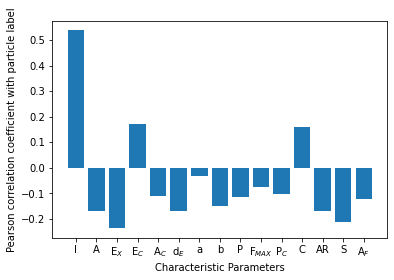

In [ ]:
plt.bar(correlation.columns, correlation.corrwith(y).values)
plt.ylabel('Pearson correlation coefficient with particle label')
plt.xlabel('Characteristic Parameters')

#NN

In [ ]:
def NN_model():
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(4,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer = 'adam',
                loss='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', 
                            mode='min',
                            verbose=1,
                            patience=25)
    return model


In [ ]:
y.value_counts()

0    5925
1    5673
Name: label, dtype: int64

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Dense(17,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)

In [ ]:
for i in range (10):
    X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df = preprocessing(df)
    NN_model()
    model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)
    y_pred = pd.DataFrame((model.predict(X) > 0.5).astype("int32"))
    print(i,accuracy_score(y,y_pred))
    print(confusion_matrix(y,y_pred))

Epoch 112: early stopping
363/363 [==============================] - 1s 1ms/step
0 0.957147784100707
[[5710  215]
 [ 282 5391]]
Epoch 35: early stopping
363/363 [==============================] - 1s 1ms/step
1 0.9577513364373168
[[5678  247]
 [ 243 5430]]
Epoch 35: early stopping
363/363 [==============================] - 1s 1ms/step
2 0.9577513364373168
[[5647  278]
 [ 212 5461]]
Epoch 31: early stopping
363/363 [==============================] - 1s 2ms/step
3 0.9588722193481635
[[5781  144]
 [ 333 5340]]
Epoch 26: early stopping
363/363 [==============================] - 1s 1ms/step
4 0.9612864286946026
[[5755  170]
 [ 279 5394]]
Epoch 35: early stopping
363/363 [==============================] - 1s 2ms/step
5 0.9605104328332471
[[5693  232]
 [ 226 5447]]
Epoch 29: early stopping
363/363 [==============================] - 1s 1ms/step
6 0.9612864286946026
[[5679  246]
 [ 203 5470]]
Epoch 29: early stopping
363/363 [==============================] - 1s 1ms/step
7 0.9618899810312123
[[5

In [ ]:
model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)

model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)

#y_pred = pd.DataFrame((model.predict(X_test) > 0.5).astype("int32"))
#print(accuracy_score(y_test,y_pred))
#print(confusion_matrix(y_test,y_pred))

Epoch 192: early stopping


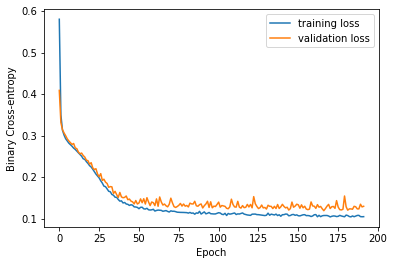

In [ ]:
history = pd.DataFrame(model.history.history)
plt.plot(history)
plt.ylabel('Binary Cross-entropy')
plt.xlabel('Epoch')
plt.gca().legend(('training loss','validation loss'))

In [ ]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame((model.predict(X_test) > 0.5).astype("int32"))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

109/109 [==============================] - 0s 1ms/step
0.953735632183908
[[1706   59]
 [ 102 1613]]
F1 Score: 0.952
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1765
           1       0.96      0.94      0.95      1715

    accuracy                           0.95      3480
   macro avg       0.95      0.95      0.95      3480
weighted avg       0.95      0.95      0.95      3480



# ML

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
models = {
    'K-Neighbors Classifier':KNeighborsClassifier(),
          'Logistic Regression':LogisticRegression(max_iter=500),
          'SVC': SVC(),
         'Decision Tree Classifier':DecisionTreeClassifier(),
          'Random Forest Classifier':RandomForestClassifier(),
      #    'Ad aBoost Classifier':AdaBoostClassifier(),
        #  'Gaussian NB':GaussianNB()
         }
score = []
x=0
#results = pd.DataFrame(y_test)
for name,model in models.items():
    x+=1
    #model.fit(X,y)
   # y_pred = model.predict(X_test)
    cvs = cross_val_score(estimator= model,X=X,y=y,cv=10)
    acc = cvs.mean()
    std = cvs.std()
    #score.append([name,accuracy_score(y_test,y_pred)])
    print(x,'/',len(models),name,round(acc,3),round(std,3))
    #y_pred = cross_val_predict(model, X=X, y=y, cv=10)
    #print(confusion_matrix(y, y_pred)) 
    score.append([name,acc, std])

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(confusion_matrix(y_test, y_pred)) 
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    classification_report
    #results[name] = y_pred
score = pd.DataFrame(score, columns=['model name', 'Accuracy','std'])

1 / 5 K-Neighbors Classifier 0.875 0.015
K-Neighbors Classifier
[[1579  186]
 [ 273 1442]]
F1 Score: 0.863
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1765
           1       0.89      0.84      0.86      1715

    accuracy                           0.87      3480
   macro avg       0.87      0.87      0.87      3480
weighted avg       0.87      0.87      0.87      3480

2 / 5 Logistic Regression 0.924 0.053
Logistic Regression
[[1655  110]
 [ 147 1568]]
F1 Score: 0.924
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1765
           1       0.93      0.91      0.92      1715

    accuracy                           0.93      3480
   macro avg       0.93      0.93      0.93      3480
weighted avg       0.93      0.93      0.93      3480

3 / 5 SVC 0.909 0.019
SVC
[[1659  106]
 [ 221 1494]]
F1 Score: 0.901
              precision    recall  f1-score   support

           0  

In [ ]:
score = score.sort_values('Accuracy',ascending=False)

In [ ]:
#score.append(['NN'],0.94,0.007])

score.loc[len(df.index)] = ['Neural Network',0.94,0.007]
score = score.sort_values('Accuracy',ascending=True)

In [ ]:
score

,model name,Accuracy,std
3,Decision Tree Classifier,0.854204,0.020446
0,K-Neighbors Classifier,0.874810,0.015111
4,Random Forest Classifier,0.900334,0.020568
2,SVC,0.908782,0.018518
1,Logistic Regression,0.923530,0.052527
12537,Neural Network,0.940000,0.007000


Text(0, 0.5, 'Machine Learning Model')

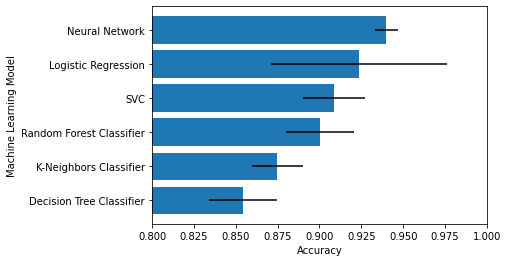

In [ ]:
plt.barh(score['model name'],score['Accuracy'],
         xerr=score['std']
         )
plt.xlim([0.80, 1])
plt.xlabel('Accuracy')
plt.ylabel('Machine Learning Model')

# Data presantation

In [ ]:
sns_plot_df = df.copy()
sns_plot_df = sns_plot_df.reset_index()


In [ ]:
len(df.columns)

21

<AxesSubplot:>

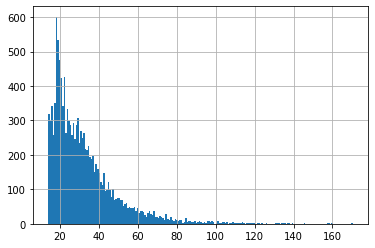

In [ ]:
df['equivalent_diameter'].hist(bins=200)

<AxesSubplot:>

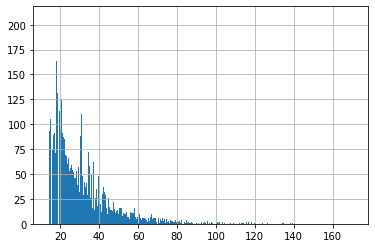

In [ ]:
df['equivalent_diameter'].hist(bins=1000)

In [ ]:
for i in X_df.sort_values('area',ascending=False).head(10).index.values:
    print(int(i))

198
24
178
456
261
58
414
190
700
48


In [ ]:
test = df.reset_index()

In [ ]:
data_nm.sort_values('area',ascending=False).head(3)

,mean_intensity,area,extent,eccentricity,convex_area,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,feret_diameter_max,...,convex_image,img,convex_perimeter,circularity,aspect_ratio,solidity,convexity,filename,area_fraction,label
52,39.279918,15012.652562,0.300197,0.894534,40681.827353,138.255933,349.330901,156.151059,1837.670222,315.370930,...,"[[False, False, False, False, False, False, Fa...","[[[108, 91, 109, 117, 103, 96, 102, 104, 104, ...",828.640400,0.236356,0.447000,0.369026,0.450919,210902_#9_150_30_1um_i005,14910.010535,1
276,40.914160,9819.751430,0.331189,0.655926,20180.942789,111.816349,188.172691,142.037495,1027.946799,198.204840,...,"[[False, True, True, True, True, True, True, T...","[[[144, 142, 146, 143, 128, 121, 122, 126, 144...",584.350712,0.341731,0.754825,0.486585,0.568464,210902_#9_150_30_1um_i005,9752.613448,1
203,30.367362,8558.442506,0.283993,0.853570,20193.248242,104.388445,223.115902,116.238492,1239.859476,229.815152,...,"[[False, True, True, True, True, True, True, T...","[[[134, 154, 134, 129, 117, 124, 119, 122, 115...",577.687449,0.264503,0.520978,0.423827,0.465930,210902_#9_150_30_1um_i005,8499.928137,1


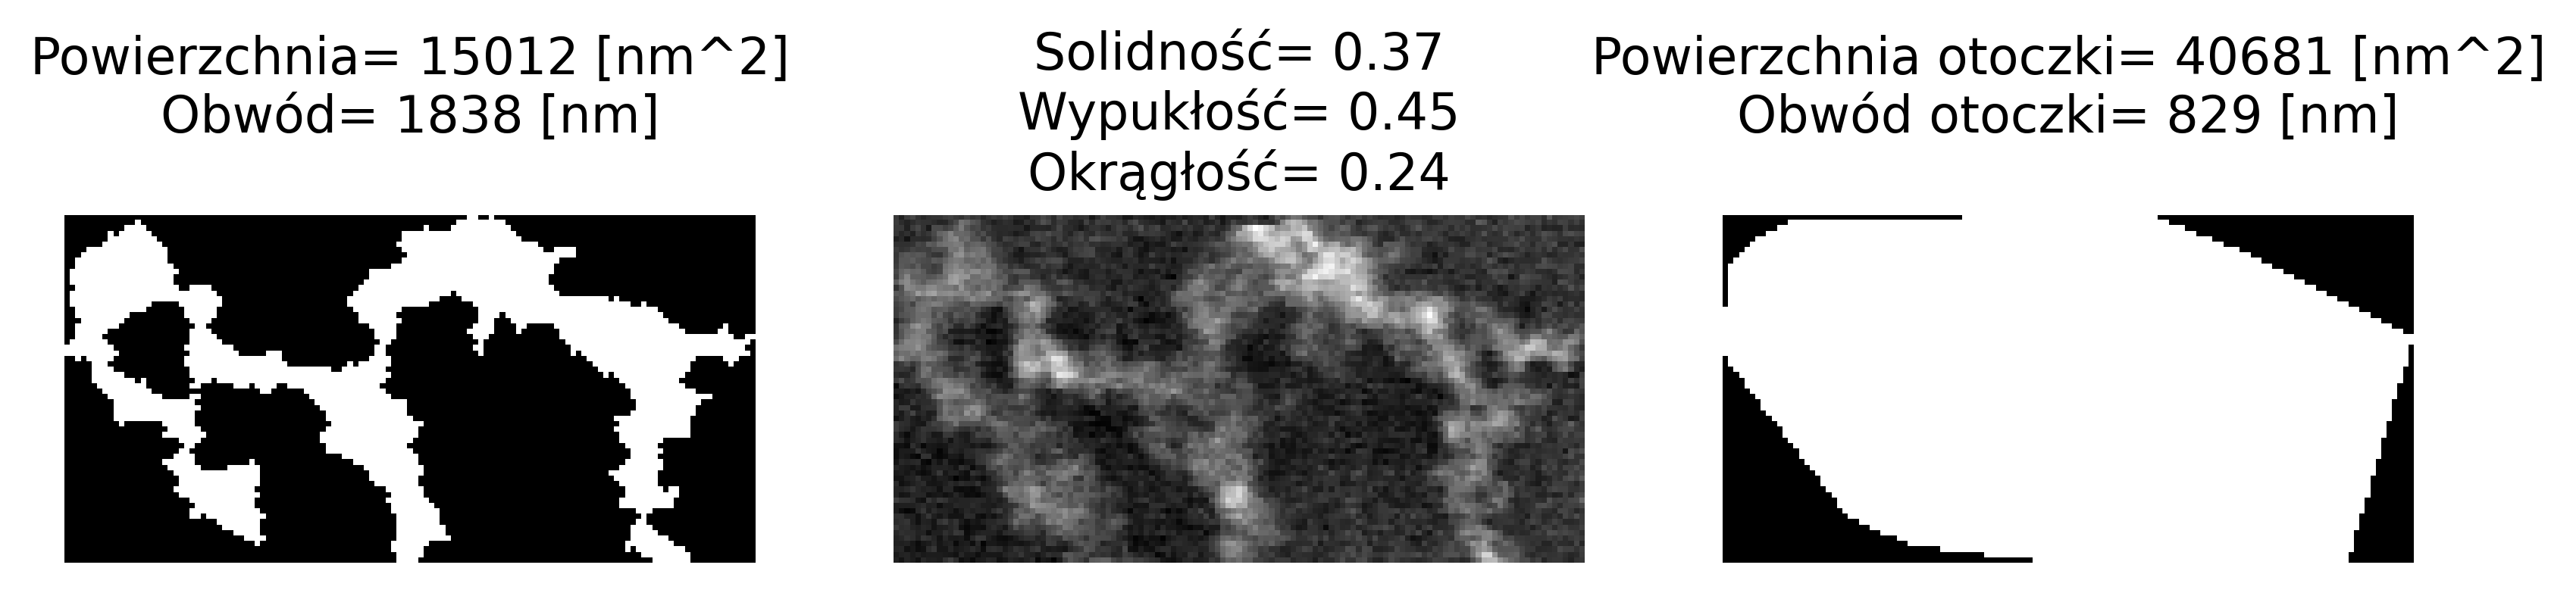

In [ ]:
index=52
plt.figure(figsize=(10,10),dpi=400)
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Powierzchnia= '+str(int(data_nm['area'][index]))+' [nm^2]\n'
          'Obwód= '+str(round(data_nm['perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['image'][index],cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Solidność= '+str(round(data_nm['solidity'][index],2))+'\n'
        'Wypukłość= '+str(round(data_nm['convexity'][index],2))+'\n'
        'Okrągłość= '+str(round(data_nm['circularity'][index],2)))
plt.imshow(data_nm['img'][index][0],cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Powierzchnia otoczki= '+str(int(data_nm['convex_area'][index]))+' [nm^2]\n'
           'Obwód otoczki= '+str(round(data_nm['convex_perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['convex_image'][index],cmap='gray')
plt.show()

<AxesSubplot:title={'center':'Solidity'}>

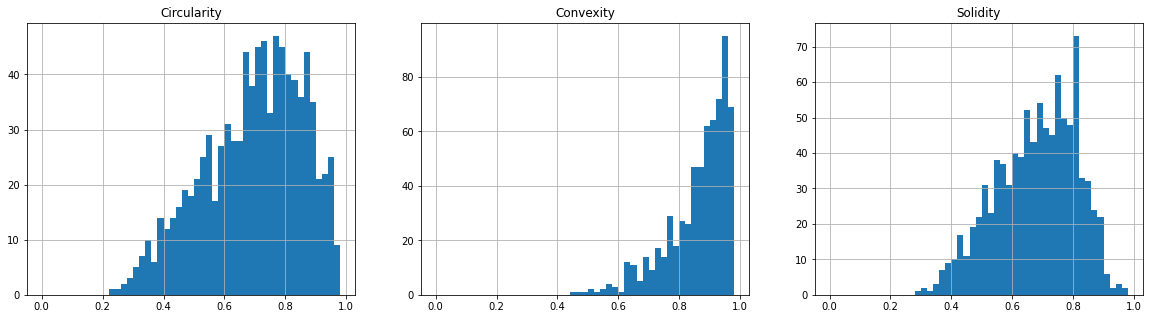

In [ ]:
bins = np.arange(0, 1, 0.02)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('Circularity')
data_nm['circularity'].hist(bins=bins)

plt.subplot(1,3,2)
plt.title('Convexity')
data_nm['convexity'].hist(bins=bins)

plt.subplot(1,3,3)
plt.title('Solidity')
data_nm['solidity'].hist(bins=bins)